In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Install dependencies**

In [1]:
!pip install -U -q segmentation-models
!pip install tensorflow==2.4
!pip install keras==2.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Import Libraries**

In [2]:
import os
os.environ['TF_KERAS'] = '1'
from skimage import color
import tensorflow as tf
import segmentation_models as sm
import glob
from tensorflow.keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.layers import Flatten
import cv2
import os
from matplotlib import pyplot as plt
import keras 
from tensorflow.keras.utils import normalize
from keras.metrics import MeanIoU
import numpy as np
from skimage.transform import AffineTransform, warp
from keras.models import load_model
import torchvision.models as models
from skimage import io, img_as_ubyte
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
import random
import numpy as np 
import os
import numpy as np
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.optimizers import *
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import utils
import tensorflow.keras as keras
from random import randint,choice
from scipy.ndimage import rotate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.optimizers import *
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import utils
import tensorflow.keras as keras
from natsort import natsorted
from tensorflow.keras.models import Sequential,  Model
from keras import Sequential, layers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,BatchNormalization,Add,GlobalAveragePooling2D,UpSampling2D

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


**Functions for measuring accuracies**

In [3]:
epsilon = 1e-5
def iou_coef1(y_true, y_pred):
  intersection = K.sum((y_true * y_pred))
  union = K.sum(y_true)+K.sum(y_pred)-intersection
  iou = K.mean((intersection) / (union))
  return iou
def dice_coef( y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + K.epsilon()) / (
                    K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
def f1( y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        v1 =  K.sum(y_true_f) / intersection
        v2 =  K.sum(y_pred_f)/ intersection
        return (2+ K.epsilon()) / (
                   v1 + v2 + K.epsilon())        
def sensitivity( y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())
        
def specificity( y_true, y_pred):
        true_negatives = K.sum(
            K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
        return true_negatives / (possible_negatives + K.epsilon())         

**Data augmentation using custom data augmentation functions**

In [4]:
def rotation(image, seed):
    random.seed(seed)
    angle= random.randint(-180,180)
    rotated_img = rotate(image, angle, mode='reflect', reshape=False, order=0)
    return rotated_img

def h_flip(image, seed):
    hflipped_img= np.fliplr(image)
    return  hflipped_img

def v_flip(image, seed):
    vflipped_img= np.flipud(image)
    return vflipped_img

def v_transl(image, seed):
    random.seed(seed)
    n_pixels = random.randint(-64,64)
    vtranslated_img = np.roll(image, n_pixels, axis=0)
    return vtranslated_img

def h_transl(image, seed):
    random.seed(seed)
    n_pixels = random.randint(-64,64)
    htranslated_img = np.roll(image, n_pixels, axis=1)
    return htranslated_img
seed_for_random = 7
transformations = {'rotate': rotation,
                    'horizontal flip': h_flip, 
                    'vertical flip': v_flip,
                   'vertical shift': v_transl,
                   'horizontal shift': h_transl
                 }               

images_path="/content/drive/MyDrive/A3_Dataset/dataset1/images_prepped_train" #path to original images
masks_path ="/content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train" #path to original masks
img_augmented_path="/content/drive/MyDrive/A3_Dataset/dataset1/images_prepped_train" # path to store aumented images
msk_augmented_path="/content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train"# path to store aumented masks
images=[] # to store paths of images from folder
masks=[]

for im in os.listdir(images_path):  # read image name from folder and append its path into "images" array     
    images.append(os.path.join(images_path,im))

for msk in os.listdir(masks_path):  # read image name from folder and append its path into "images" array     
    masks.append(os.path.join(masks_path,msk))

i=0   # variable to iterate till images_to_generate
#iterate over all images
while i<367: 
    image = images[i]
    mask = masks[i]
    original_image = io.imread(image)
    original_mask = io.imread(mask)
    transformed_image = None
    transformed_mask = None
    key = np.random.choice(list(transformations)) #randomly choosing method to call
    #print(key)
    seed = random.randint(1,100)  #Generate seed to supply transformation functions. 
    transformed_image = transformations[key](original_image, seed)
    transformed_mask = transformations[key](original_mask, seed)
    new_image_path= "%s/augmented_image_%s.png" %(img_augmented_path, i)
    new_mask_path = "%s/augmented_mask_%s.png" %(msk_augmented_path, i)   #Do not save as JPG
    io.imsave(new_image_path, transformed_image)
    io.imsave(new_mask_path, transformed_mask)
    i =i+1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train/augmented_mask_0.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train/augmented_mask_1.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train/augmented_mask_2.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train/augmented_mask_3.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train/augmented_mask_4.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/i

**Functions for reading images and masks**

In [5]:
def readImages(path):
  #names array reads the names of the files and sort them in ascending order by using natsorted library
  #this sorting is required because cv2.imread reads images randomly so some masks doesn't corresponds to their respective images
  names = []
  images = []
  # x and y defines the height and width size of the newly resized images so convolutions can be applied easily
  x = 128
  y = 128
  # this loop reads the names of the image files and stores them in names list
  for directory_path in glob.glob(path):
    for name_path in glob.glob(os.path.join(directory_path, "*.png")):
        names.append(name_path)
  names = natsorted(names)  
  # this loop reads the images in ascending order to ensure every mask matches their respective image
  for i in range(len(names)):
        #imgs.append(img_path)
        img = cv2.imread(names[i], 1)       
       # print(names[i] + " img")
        img = cv2.resize(img, (x, y))
        #plt.imshow(img)
        images.append(img)     
#Convert list to array for machine learning processing        
  images = np.array(images)
  return images 
def readMasks(path):
  #names array reads the names of the files and sort them in ascending order by using natsorted library
  #this sorting is required because cv2.imread reads images randomly so some masks doesn't corresponds to their respective images
  names = []
  masks = []
  # x and y defines the height and width size of the newly resized images so convolutions can be applied easily
  x = 128
  y = 128
  # this loop reads the names of the image files and stores them in names list
  for directory_path in glob.glob(path):
    for name_path in glob.glob(os.path.join(directory_path, "*.png")):
        names.append(name_path)
  names = natsorted(names)  
  # this loop reads the images in ascending order to ensure every mask matches their respective image
  for i in range(len(names)):
        #imgs.append(img_path)
        msk = cv2.imread(names[i], 0)       
        #print(names[i] + " mask")
        msk = cv2.resize(msk, (x, y), interpolation = cv2.INTER_NEAREST)
        #plt.imshow(img)
        masks.append(msk)     
#Convert list to array for machine learning processing        
  masks = np.array(masks)
  return masks
#As mask consist of various classes of object for each pixel therefore, each class is a category thus we convert mask classes to OHE  
def oneHotEncoder(imagesMasks):
  n_classes = 12
  #imagesMasks = readImages("/content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/")
  labelencoder = LabelEncoder()
  n, h, w = imagesMasks.shape
  masks_reshaped = imagesMasks.reshape(-1,1)
  masks_reshaped_encoded = labelencoder.fit_transform(masks_reshaped)
  masks_encoded_original_shape = masks_reshaped_encoded.reshape(n, h, w)

  np.unique(masks_encoded_original_shape)
  train_masks_input = np.expand_dims(masks_encoded_original_shape, axis=3)
  train_masks_cat = to_categorical(train_masks_input, num_classes=n_classes)
  y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))
  return y_train_cat


**Custom Resnet50 with Atrous Spatial Pyramid Pooling layers**

In [6]:
def identity_block(input_x, filters):
    
    filters_1, filters_2, filters_3 = filters

    x = Conv2D(filters_1, (1, 1))(input_x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters_2, 3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters_3, (1, 1))(x)
    x = BatchNormalization()(x)
    
    x = add([x, input_x])
    x = Activation('relu')(x)
    return x


def conv_block(input_x, filters, strides=(2, 2)):

    filters_1, filters_2, filters_3 = filters



    x = Conv2D(filters_1, (1, 1), strides=strides)(input_x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters_2, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters_3, (1, 1))(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters_3, (1, 1),
                      strides=strides)(input_x)
    shortcut = BatchNormalization()(shortcut)


    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x


def resnet50_encoder(pretrained_weights = 'imagenet', num_classes = 20, input_size = (256,256,1)):

    pretrained_url = "https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

    inp = Input(input_size)

    x = ZeroPadding2D((3, 3))(inp)
    x = Conv2D(64, (7, 7),
               strides=(2, 2))(x)
    feature_map_1 = x

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, [64, 64, 256])
    x = identity_block(x, [64, 64, 256])
    feature_map_2 = ZeroPadding2D((1, 1))(x)
    feature_map_2 = Lambda(lambda x: x[:, :-1, :-1, :])(feature_map_2)

    x = conv_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    feature_map_3 = x

    x = conv_block(x, [256, 256, 1024])
    x = identity_block(x,  [256, 256, 1024])
    x = identity_block(x,  [256, 256, 1024])
    x = identity_block(x,  [256, 256, 1024])
    x = identity_block(x,  [256, 256, 1024])
    x = identity_block(x,  [256, 256, 1024])
    feature_map_4 = x

    x = conv_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])
    feature_map_5 = x




    model = Model(inputs = inp, outputs = feature_map_5)


    if pretrained_weights == 'imagenet':
        weights_path = tf.keras.utils.get_file(pretrained_url.split("/")[-1], pretrained_url)
        model.load_weights(weights_path)

    return inp,[feature_map_1,feature_map_2,feature_map_3,feature_map_4,feature_map_5]

def resnet50_encoder_unet_decoder(pretrained_weights = None, num_classes = 12, input_size = (128,128,3)):
    inp, feature_map_list= resnet50_encoder(pretrained_weights = 'imagenet', num_classes = num_classes, input_size = input_size)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(feature_map_list[4]))
    merge6 = concatenate([feature_map_list[3],up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([feature_map_list[2],up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([feature_map_list[1],up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([feature_map_list[0],up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv9)
    
    up10 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv9))
    merge9 = concatenate([inp,up10], axis = 3)
    conv10 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge9)
    conv10 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv10)
    out = Conv2D(64, (1, 1), dilation_rate=2)(conv10)
    #ASPP layers
    atrous_rates = (6, 12, 18)
    x = conv10
    b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
    b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
    b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
    x = Concatenate()([b1, b2, b3])
    merge10= concatenate([x, conv10], axis = 3)
    conv11 = Conv2D(12, 1, activation = 'softmax')(merge10)
    #print(merge10.shape)
    model = Model(inputs = inp, outputs = conv11)

    model.compile(optimizer = 'adam', loss = total_loss, metrics =metrics)
    if(pretrained_weights):
        model.load_weights(pretrained_weights)
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='multichanne2.png')
    return model
 
def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
 
    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)

    return x
   

**Function for displaying training  graphs**

In [7]:
def trainingGraph(history_):
  loss = history_.history['loss']
  #val_loss = history_.history['val_loss']
  epochs = range(0, len(loss))
  plt.plot(epochs, loss, 'y', label='Training loss')
  #plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  acc = history_.history['iou_score']
  #val_acc = history_.history['val_iou_score']

  plt.plot(epochs, acc, 'y', label='Training IOU')
  #plt.plot(epochs, val_acc, 'r', label='Validation IOU')
  plt.title('Training IOU')
  plt.xlabel('Epochs')
  plt.ylabel('IOU')
  plt.legend()
  plt.show()



**metric for model**

In [8]:
#n_classes=12
#activation='softmax'
#LR = 0.0001
#modelOptimizer = tf.keras.optimizers.Adam(LR)
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.083, 0.083, 0.083, 0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.083])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
  # actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
  # total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), "accuracy", dice_coef ]  

**Function for displaying predicted mask along with original mask and  overlapped mask on original image**

In [9]:
def correct_Incorrect(models, testing_images, y_masks,testingMasks, test_img_number, model):
 # preprocess_input = sm.get_preprocessing(models)
  test_img_number = test_img_number
  test_img = testing_images[test_img_number]
  ground_truth=y_masks[test_img_number]
  test_img_input=np.expand_dims(test_img, 0)
  #test_img_input1 = preprocess_input(test_img_input)
  test_pred1 = model.predict(test_img_input)
  test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]
  result_image1 = color.label2rgb(test_prediction1, testing_images[test_img_number])
  result_image = color.label2rgb(testingMasks[test_img_number],test_img )
  plt.figure(figsize=(12, 12))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,0])
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(testingMasks[test_img_number])
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(test_prediction1)
  plt.show()
  return result_image1, result_image
def overlay(image, caption):
    plt.title(caption)
    plt.imshow(image) 
    plt.show()


**Function for displaying the model prediction measures on test dataset**

In [10]:
def testMetrics(models, testing_imgs,y_masks):
  dice_coefficient_test = []
  f1_score_test = []
  sensitivity_test =[]  
  specificity_test = []
  accuracy_iou = []
  preprocess_input = sm.get_preprocessing(models)
  for i in range(101):
    test_img_number = i
    test_img = testing_imgs[test_img_number]
    ground_truth=y_masks[test_img_number]
    test_img_input=np.expand_dims(test_img, 0)
    test_img_input1 = preprocess_input(test_img_input)
    #test_pred1 = model.predict(test_img_input1)
    y_test = model.predict(test_img_input1)
    test_mask=ground_truth.astype(np.float32)
    f1_score_test.append(K.eval(f1(test_mask, y_test)))
    accuracy_iou.append(K.eval(iou_coef1(test_mask, y_test)))
    dice_coefficient_test.append(K.eval(dice_coef(test_mask, y_test)))
    sensitivity_test.append(K.eval(sensitivity(test_mask,y_test)))
    specificity_test.append(K.eval(specificity(test_mask,y_test)))
    
  print ("average of Dice Coefficient, Sensitivity, Specificity,f1-score, iou accuracy", sum(dice_coefficient_test) / 101, sum(sensitivity_test)/ 101, sum(specificity_test)/ 101, sum(f1_score_test)/ 101, sum(accuracy_iou) /101)

**Training function for getting training data**

In [11]:
def training(imgpath, maskpath):
  training_imgs = readImages(imgpath)
  training_masks = readMasks(maskpath)
  y_masks = oneHotEncoder(training_masks)
  return training_imgs, y_masks,training_masks

In [12]:
def testing(imgpath, maskpath):
  training_imgs = readImages(imgpath)
  training_masks = readMasks(maskpath)
  y_masks = oneHotEncoder(training_masks)
  return training_imgs, y_masks,training_masks

In [13]:
trainimgPath = "/content/drive/MyDrive/A3_Dataset/dataset1/images_prepped_train"
trainmaskPath = "/content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train"
training_imgs,y_masks, trainingMsks = training(trainimgPath,trainmaskPath)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
trainingMsks.shape

(734, 128, 128)

**RESNET 50 With ASPP Model Initilization**

In [ ]:
model2   = resnet50_encoder_unet_decoder(pretrained_weights = None, num_classes = 12, input_size = (128,128,3))


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         conv2d[0][0]                     
____________________________________________________________________________________________

In [ ]:
history2= model2.fit(training_imgs, 
          y_masks,
          batch_size=16, 
          epochs=50)
#model2.save('res34_backbone_50epochs2.hdf5')
tf.saved_model.save(model2, 'saved_model') 

Epoch 1/50
12/12 [==============================] - 392s 32s/step - loss: 1.0230 - iou_score: 0.0425 - f1-score: 0.0542 - accuracy: 0.4274 - dice_coef: 0.2196
Epoch 2/50
12/12 [==============================] - 378s 31s/step - loss: 1.0047 - iou_score: 0.1369 - f1-score: 0.1588 - accuracy: 0.6373 - dice_coef: 0.4617
Epoch 3/50
12/12 [==============================] - 381s 31s/step - loss: 0.9946 - iou_score: 0.1889 - f1-score: 0.2135 - accuracy: 0.7016 - dice_coef: 0.5891
Epoch 4/50
12/12 [==============================] - 377s 31s/step - loss: 0.9896 - iou_score: 0.2155 - f1-score: 0.2454 - accuracy: 0.7368 - dice_coef: 0.6404
Epoch 5/50
12/12 [==============================] - 381s 32s/step - loss: 0.9851 - iou_score: 0.2460 - f1-score: 0.2855 - accuracy: 0.7712 - dice_coef: 0.6830
Epoch 6/50
12/12 [==============================] - 376s 31s/step - loss: 0.9795 - iou_score: 0.3172 - f1-score: 0.3760 - accuracy: 0.8137 - dice_coef: 0.7376
Epoch 7/50
12/12 [============================

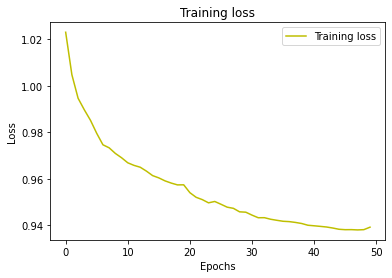

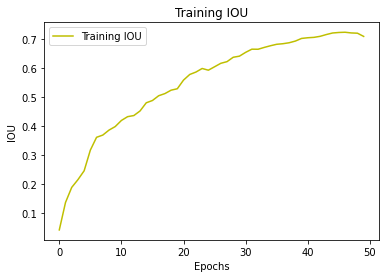

In [ ]:
trainingGraph(history2)

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/resnet50_atrous.hdf5', compile=False)

In [14]:
testPath = "/content/drive/MyDrive/A3_Dataset/dataset1/images_prepped_test"
testmaskPath = "/content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_test"
testing_imgs,testingy_masks, testingMsks = testing(testPath,testmaskPath)

**Predicted masks and superimposed results on original image**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


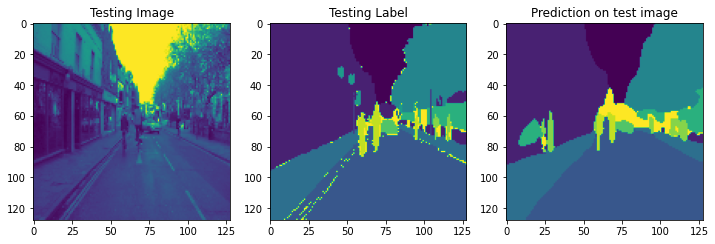

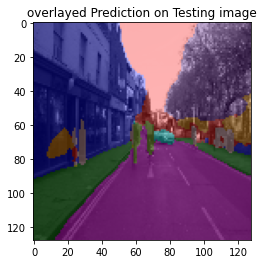

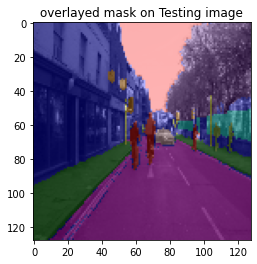

In [ ]:
result1, result2 = correct_Incorrect("Resnet50-ASPP",testing_imgs,testingy_masks,testingMsks,10)
overlay(result1, "overlayed Prediction on Testing image")
overlay(result2, "overlayed mask on Testing image")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


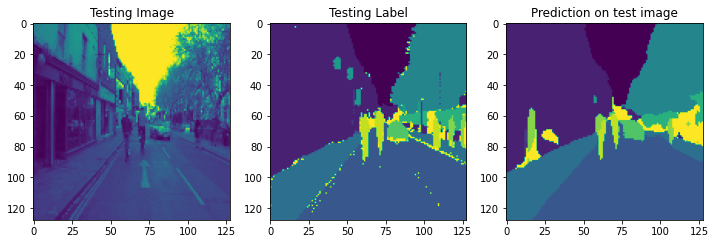

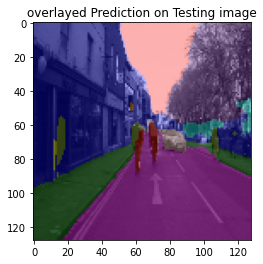

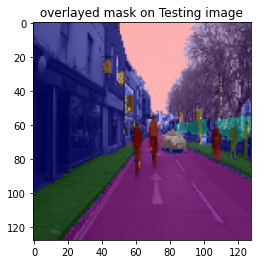

In [ ]:
result1, result2 = correct_Incorrect("Resnet50-ASPP",testing_imgs,testingy_masks,testingMsks,20)
overlay(result1, "overlayed Prediction on Testing image")
overlay(result2, "overlayed mask on Testing image")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


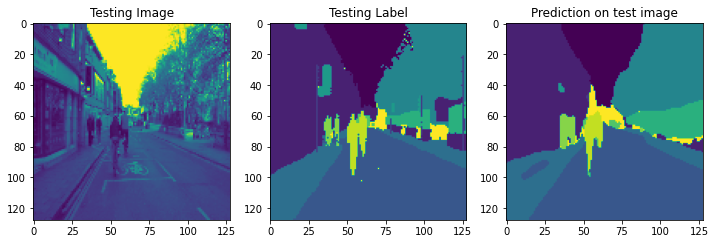

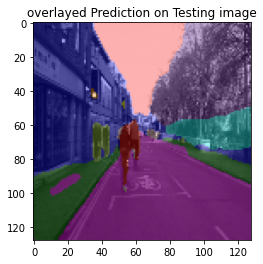

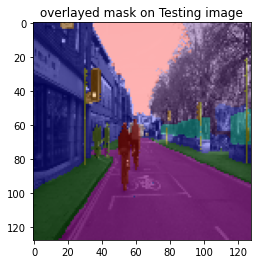

In [ ]:
result1, result2 = correct_Incorrect("Resnet50-ASPP",testing_imgs,testingy_masks,testingMsks,55)
overlay(result1, "overlayed Prediction on Testing image")
overlay(result2, "overlayed mask on Testing image")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


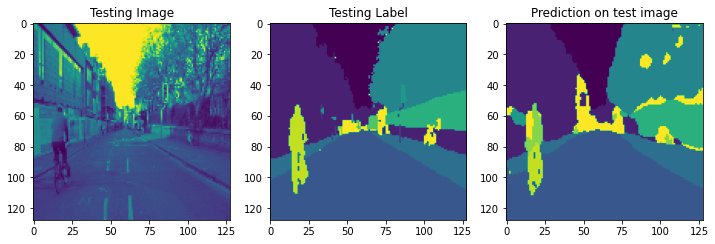

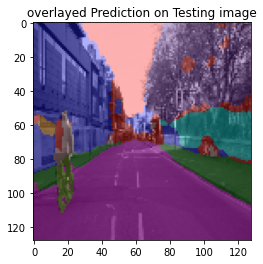

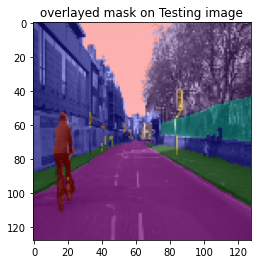

In [ ]:
result1, result2 = correct_Incorrect("Resnet50-ASPP",testing_imgs,testingy_masks,testingMsks,100)
overlay(result1, "overlayed Prediction on Testing image")
overlay(result2, "overlayed mask on Testing image")


In [ ]:
testMetrics("resnet50", testing_imgs, testingy_masks)



average of Dice Coefficient, Sensitivity, Specificity,f1-score, iou accuracy 0.8608846605414211 0.8663795395652847 0.9892502314973586 0.8608846398863462 0.7571347656816539
